### Part 1 - Spectral Unmixing

#### Tasks

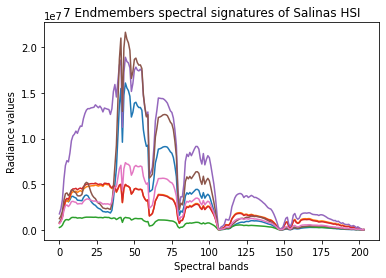

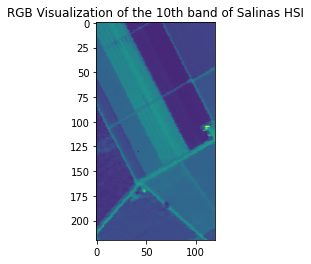

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
import pandas as pd 
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

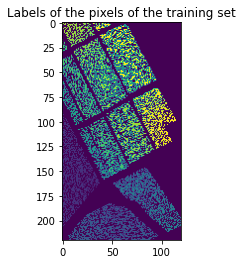

In [2]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

#### Intro - Intuition

In [3]:
# Making a non zero label 2dim array which contains either 1 or 0 to then multiply with the theta values
# to make them also zero if they are on a zero label pixel 

non_zero_labels = np.zeros((220,120))
Training_Set.shape
for i in range(220):
    for j in range(120):
        if Training_Set[i][j] != 0:
            non_zero_labels[i][j] = Training_Set[i][j] / Training_Set[i][j]
non_zero_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
# Unique Spectral Signature of the endmembers
grapes_spectral_signature   = endmembers[:,0]
broccoli_spectral_signature = endmembers[:,1]
fallow1_spectral_signature  = endmembers[:,2]
fallow2_spectral_signature  = endmembers[:,3]
fallow3_spectral_signature  = endmembers[:,4]
stubble_spectral_signature  = endmembers[:,5]
celery_spectral_signature   = endmembers[:,6]

spectral_signatures = [grapes_spectral_signature, 
                       broccoli_spectral_signature, 
                       fallow1_spectral_signature, 
                       fallow2_spectral_signature, 
                       fallow3_spectral_signature,
                       stubble_spectral_signature,
                       celery_spectral_signature]


In [5]:
# Define X values as the Spectral Signatures of the 7 endmembers. If we assume that our problem is linear with Y = X*theta + noise,
# then we should have x1,x2,..,x7 each for every endmember. x1 will be the first column of our 2d np array, x2 the second etc..

X = np.column_stack((grapes_spectral_signature, 
                     broccoli_spectral_signature, 
                     fallow1_spectral_signature, 
                     fallow2_spectral_signature, 
                     fallow3_spectral_signature,
                     stubble_spectral_signature,
                     celery_spectral_signature))

#### Least Squares

In [6]:
def leastSquare(X, y):
    theta = np.zeros((X.shape[1], 1))
    theta = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y))
    return theta

In [7]:
# This is the array that will "house" our 7 theta values for every pixel
thetas = np.zeros((220, 120, 7))

In [8]:
for i in range(0,220):
    for j in range(0,120):
        thetas[i,j] = leastSquare(X,HSI[i,j,:])

In [9]:
# Normalize the thetas and bring them into 0-1 range 
# Keep that and we will see if we will need those 

normal_thetas = thetas/np.linalg.norm(thetas)

# Multiply thetas with non_zero_labels to exclude all zero label pixels
for i in range(0,7):
    thetas[:,:,i] = thetas[:,:,i]*non_zero_labels[:,:]

Reconstruction Error

In [10]:
def reconstruction_error(thetas):
    recon_error = np.empty((220,120,204))
    for i in range(0,220):
        for j in range(0,120):
            if non_zero_labels[i,j] != 0:
                recon_error[i,j,:] = np.power(HSI[i,j,:] - X.dot(thetas[i,j,:]),2)

    recon_error = recon_error.reshape(220 * 120, 204)
    recon_error = np.mean(recon_error)
    return recon_error

In [11]:
recon_error = pd.DataFrame([
    ["{:f}".format(reconstruction_error(thetas))]
], columns = ["Reconstruction error (OLS)"])
recon_error

,Reconstruction error (OLS)
0,22594660494113.246094


Abundance maps

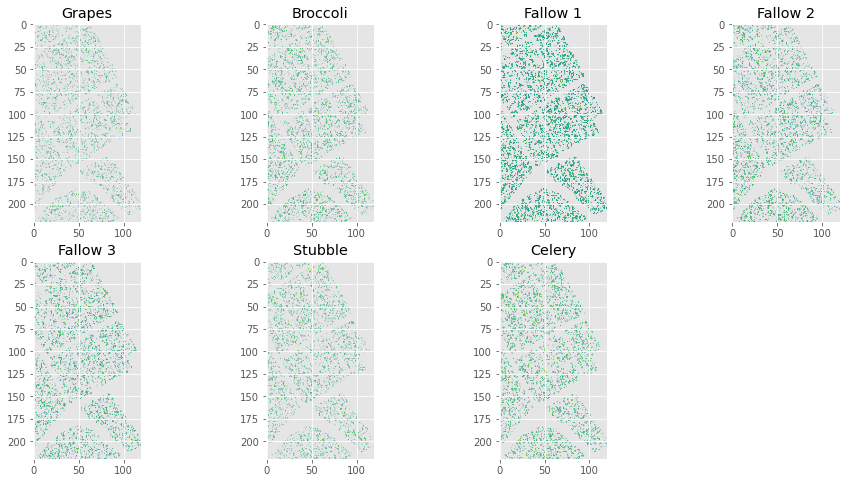

In [12]:
endmembers=["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust()

for i in range(0,7):
    nrows, ncols, plot_number = 2, 4, i+1
    plt.subplot(nrows, ncols, plot_number)
    plt.imshow(thetas[:,:,i],alpha=thetas[:,:,i])
    plt.title(f"{endmembers[i]}")
    

#### Least Squares imposing the sum to one constraint

In [13]:
from scipy.optimize import minimize

In [14]:
# Sum-to-one constraint
constraints = ({
    "type": "eq",
    "fun": lambda x: np.sum(x) - 1.0
})

def loss_function(x, X, y):
    return np.sum(np.square((np.dot(x, X) - y)))

def spectral_unmixing_sum_to_one(HSI, X, labels):
    M, N, L, C = 220,120,204,7
    
    # Sum-to-one constraint
    constraints = ({
        "type": "eq",
        "fun": lambda x: np.sum(x) - 1.0
    })
    
    # Initialization of parameters for the minimization function
    x0 = np.zeros(X.shape[0])
    
    thetas = np.zeros((M, N, C), np.float64)
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                thetas[i, j, :] = minimize(loss_function, x0, method = "SLSQP", constraints = constraints, args = (X, HSI[i, j, :].reshape(1, L))).x
                
    return thetas

In [15]:
X_reshaped = X.reshape(7, 204)
thetas_sum_to_one = spectral_unmixing_sum_to_one(HSI, X_reshaped, labels)

Reconstruction error for the constrained sum-to-one Least Squares Method

In [16]:
recon_error = pd.DataFrame([
    ["{:f}".format(reconstruction_error(thetas_sum_to_one))]
], columns = ["Reconstruction error (LS Sum_To_One)"])
recon_error

,Reconstruction error (LS Sum_To_One)
0,682015785936673357644693504.000000


Abundance maps for the constrained sum-to-one Least Squares method

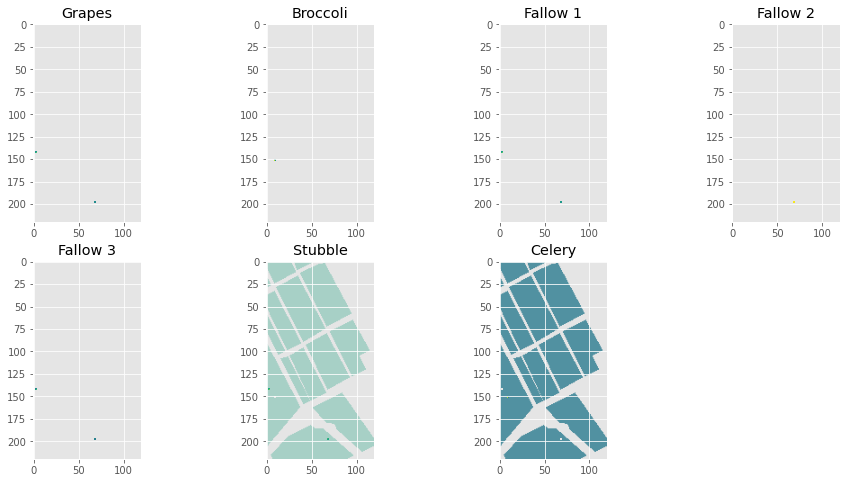

In [17]:
endmembers=["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust()

for i in range(0,7):
    nrows, ncols, plot_number = 2, 4, i+1
    plt.subplot(nrows, ncols, plot_number)
    plt.imshow(thetas_sum_to_one[:,:,i],alpha=thetas_sum_to_one[:,:,i])
    plt.title(f"{endmembers[i]}")

#### Lasso, i.e., impose sparsity on θ via 𝑙1 norm minimization

In [ ]:
from sklearn.linear_model import Lasso

clf = Lasso(alpha=0.1,positive=True, random_state=1234, selection='random')

lasso_thetas = np.zeros((220, 120, 7))
for i in range(0,220):
    for j in range(0,120):
        clf.fit(X,HSI[i,j,:])
        lasso_thetas[i,j] = clf.coef_

In [19]:
# Multiply thetas with non_zero_labels to exclude all zero label pixels
for i in range(0,7):
    lasso_thetas[:,:,i] = lasso_thetas[:,:,i]*non_zero_labels[:,:]

Lasso abundance map 

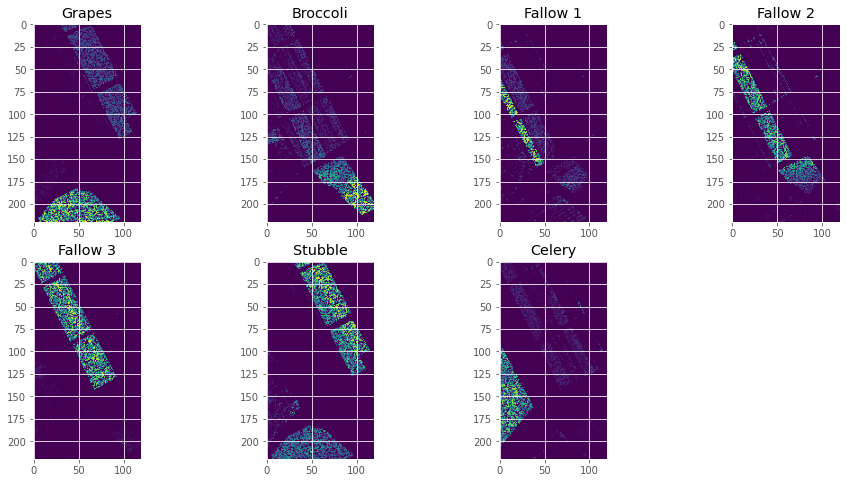

In [20]:
endmembers=["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust()

for i in range(0,7):
    nrows, ncols, plot_number = 2, 4, i+1
    plt.subplot(nrows, ncols, plot_number)
    plt.imshow(lasso_thetas[:,:,i])
    plt.title(f"{endmembers[i]}")

Reconstruction error

In [21]:
recon_error = pd.DataFrame([
    ["{:f}".format(reconstruction_error(lasso_thetas))]
], columns = ["Reconstruction error (Lasso)"])
recon_error

,Reconstruction error (Lasso)
0,427.774812


#### Least squares imposing the non-negativity constraint on the entries of θ 

In [22]:
from scipy.optimize import nnls

nnls_thetas = np.zeros((220, 120, 7))
for i in range(0,220):
    for j in range(0,120):
        nnls_thetas[i,j] = nnls(X,HSI[i,j,:])[0]     

In [23]:
# Multiply thetas with non_zero_labels to exclude all zero label pixels
for i in range(0,7):
    nnls_thetas[:,:,i] = nnls_thetas[:,:,i]*non_zero_labels[:,:]

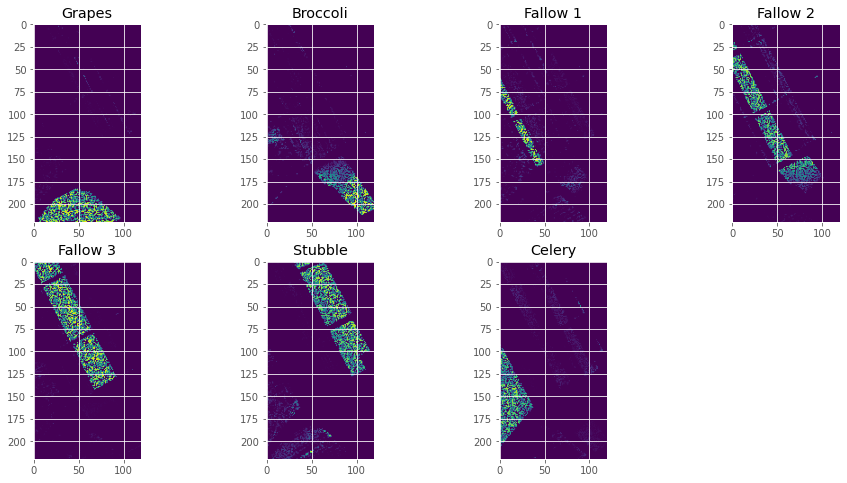

In [24]:
endmembers=["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust()

for i in range(0,7):
    nrows, ncols, plot_number = 2, 4, i+1
    plt.subplot(nrows, ncols, plot_number)
    plt.imshow(nnls_thetas[:,:,i])
    plt.title(f"{endmembers[i]}")

Reconstruction Error

In [25]:
recon_error = pd.DataFrame([
    ["{:f}".format(reconstruction_error(nnls_thetas))]
], columns = ["Reconstruction error (Non negative LS)"])
recon_error

,Reconstruction error (Non negative LS)
0,264.724952


#### Least squares imposing both the non-negativity and the sum-to-one constraint

In [26]:
def sum_to_one_constraint(x):
    return np.sum(x, axis = 0) - 1

def nn_constraint(x):
    return x

constraints = [
    {
        "type": "ineq", 
        "fun": nn_constraint
    },
    {
        "type": "eq", 
        "fun": sum_to_one_constraint
    }
]

def loss_function(x, X, y):
    x = x.reshape(1, 7)

    return np.sum(np.square((np.dot(x, X.T) - y)))

def spectral_unmixing_nn_sum_to_one(HSI, X, labels):
    M, N, L, C = 220,120,204,7
    
    constraints = [
        {
            "type": "ineq", 
            "fun": nn_constraint
        },
        {
            "type": "eq", 
            "fun": sum_to_one_constraint
        }
    ]
    
    two_constraints_thetas = np.zeros((M, N, C), np.float64)
    
    # Get the previously defined contrstrained thetas matrix from NNLS method
    x = nnls_thetas
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]
            
            if label != 0:
                # Get a specific NNLS theta as an initialization parameter
                x0 = x[i, j, :]
                
                two_constraints_thetas[i, j, :] = minimize(loss_function, x0, method = "SLSQP", constraints = constraints, args = (X, HSI[i, j, :])).x
                
    return thetas



In [27]:
X_reshaped = X.reshape(204, 7)
two_constraints_thetas = spectral_unmixing_nn_sum_to_one(HSI, X, labels)

Reconstruction error for the Least squares method imposing non negativity and sum to one constraints

In [28]:
recon_error = pd.DataFrame([
    ["{:f}".format(reconstruction_error(two_constraints_thetas))]
], columns = ["Reconstruction error (Non negative and Sum-to-one LS)"])
recon_error

,Reconstruction error (Non negative and Sum-to-one LS)
0,22594660494113.246094


Abundance Maps for the Least squares method imposing non negativity and sum to one constraints

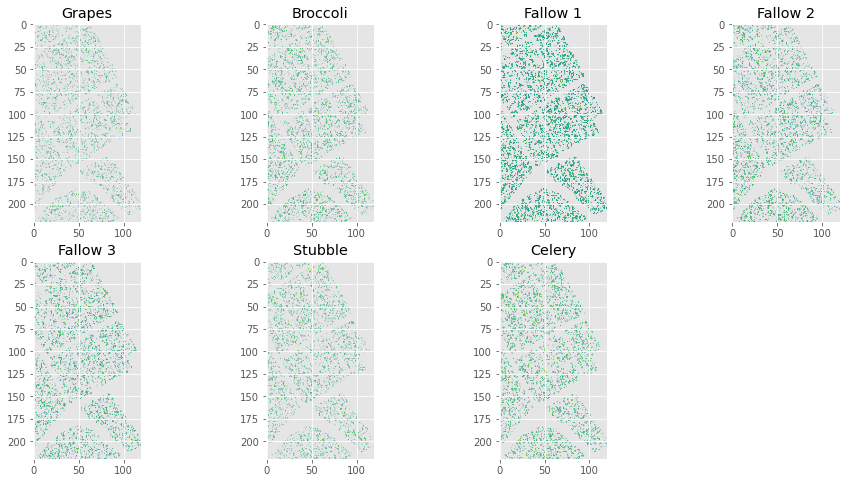

In [29]:
endmembers=["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stubble", "Celery"]
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust()

for i in range(0,7):
    nrows, ncols, plot_number = 2, 4, i+1
    plt.subplot(nrows, ncols, plot_number)
    plt.imshow(two_constraints_thetas[:,:,i],alpha=two_constraints_thetas[:,:,i])
    plt.title(f"{endmembers[i]}")

Commenting on the 1st part, we evaluate each one of the methods employed:


- Ordinary Least Squares: we expect this method to be the least performant, in terms of estimating the abundance vector of each pixel. The reason fo this is that the method does not take into consideration physical aspects of the problem, such as  the parameters $\boldsymbol{\theta}$ of the linear relationship not being negative, which would be non-sensical, as well as not impossing a meaningful constraint of weighing the parameters in such a way that the contribution of each "pure" pixel is a a percentage, related to the total contribution of "pure" pixels.


- Least squares imposing the sum-to-one constraint on $\boldsymbol{\theta}$: we expect this regressor to outperform OLS because it takes into consideration the notion that "pure" pixels contribute up to a percentage on the whole pixel value.


- Least squares imposing the non-negativity constraint on $\boldsymbol{\theta}$: this method makes sure that individual $\theta$ values cannot be negative, however it does not impose the notion that every $\theta$ parameter is normalized in such a way as to represent a contribution percentage.


- Least squares imposing both the non-negativity and the sum-to-one constraint on $\boldsymbol{\theta}$: as with the two previous method, we expect this regressor to do even better it not only takes into consideration the notion that "pure" pixels contribute up to a percentage on the whole pixel value but also that their contribution has to be non-negative.


- LASSO regularization: this method penalizes values of $\boldsymbol{\theta}$ that do not have a significant contribution in the pixel value. We estimate that this method will be much more closely aligned to a classification algorithm in which a pixel's class is derived by the probability of belonging to a certain class.

### Part 2 - Classification

#### Let's define helper functions to use for all the classification

In [30]:
# Perform 10-fold cross-validation

def cross_validate(model, X, y, n_splits = 10, shuffle = True, scoring = None):
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    
    # Define a cross validation shuffle
    cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state = 12345)

    return cross_val_score(model, X, y, cv = cv, scoring = scoring)

def score(y_test, y_pred):
    N = y_test.shape[0]
    
    accuracy = np.count_nonzero(y_test == y_pred) / N
    error = 1 - accuracy
    
    return (accuracy, error)

# To return the estimated cross-validation metrics

def score_matrix_cross_val(error, std, caption = "None"):
    df = pd.DataFrame([
        [error, std]
    ], columns = ["Estimated validation error", "Estimated validation std"])
    
    df = df.style.set_caption(caption)
    
    return df

def score_matrix_fitted(accuracy, error, caption = "None"):
    df = pd.DataFrame([
        [accuracy, error]
    ], columns = ["Accuracy (%)", "Error (%)"])
    
    df = df.style.set_caption(caption)
    
    return df

def confusion_matrix(y_test, y_pred, labels = None, caption = None):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    confusion_matrix_df = pd.DataFrame(
        data = confusion_matrix(y_test, y_pred)
    )
    
    if labels != None:
        confusion_matrix_df = confusion_matrix_df.rename(
            columns = labels, 
            index = labels
        )
    
    cmap = sns.light_palette((210, 90, 60), input="husl", as_cmap = True)
    confusion_matrix_df = confusion_matrix_df.style.background_gradient(cmap, axis = 1).set_caption(caption)
    
    return confusion_matrix_df

In [31]:
confusion_matrix_labels = {
    0: "Grapes", 
    1: "Broccoli", 
    2: "Fallow 1", 
    3: "Fallow 2", 
    4: "Fallow 3", 
    5: "Stubble", 
    6: "Celery"
}

Adjusting data sets to only use non zero labels

In [32]:
X_train = HSI[Training_Set > 0]
y_train = Training_Set[Training_Set > 0]
y_train = y_train.reshape(y_train.shape[0], 1)

X_test = HSI[Test_Set > 0]
y_test = Test_Set[Test_Set > 0]
y_test = y_test.reshape(y_test.shape[0], 1)

#### Naive Bayes Classifier

In [33]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_clf = GaussianNB()

Estimation of mean and sd metrics for the Naive Bayes

In [34]:
naive_bayes_est_val_score = cross_validate(naive_bayes_clf, X_train, y_train.ravel(), n_splits = 10, shuffle = True)

score_matrix_cross_val(
    1 - np.mean(naive_bayes_est_val_score), 
    np.std(np.ones(10) - naive_bayes_est_val_score), 
    "Naive Bayes classifier cross validation error"
)

,Estimated validation error,Estimated validation std
0,0.018546,0.004352


In [35]:
naive_bayes_clf = GaussianNB()
naive_bayes_clf_fitted = naive_bayes_clf.fit(X_train, y_train.ravel())

y_pred = naive_bayes_clf_fitted.predict(X_test)

accuracy, error = score(y_test.ravel(), y_pred.ravel())
nb_accuracy = accuracy
score_matrix_fitted(
    accuracy, 
    error,
    "Naive Bayes classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.981333,0.018667


In [36]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "Naive Bayes classifier confusion matrix")

,Grapes,Broccoli,Fallow 1,Fallow 2,Fallow 3,Stubble,Celery
Grapes,545,0,0,0,0,0,3
Broccoli,5,512,0,0,0,0,0
Fallow 1,0,0,470,0,42,0,0
Fallow 2,0,0,0,210,4,0,0
Fallow 3,0,0,12,4,547,0,0
Stubble,1,0,2,0,0,995,0
Celery,6,0,0,0,0,0,874


#### (ii) Minimum Euclidean distance classifier

In [37]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MinimumEuclideanDistanceClassifier(BaseEstimator, ClassifierMixin):
    __classes = None
    __means = None
    
    
    # Constructor
    def __init__(self):
        self.__classes = None
        self.__means = None

    # Compute unique number of classes
    def __compute_unique_classes(self, y):
        # Unique classes in the training set
        return np.unique(y)

    # Computes parameters for the classifier
    def __compute_parameters(self, X, y):
        # Means parameter placeholder 
        # (9x103 dimensional)
        means = np.empty((self.__classes.shape[0], X.shape[1]))
        
        y = y.reshape(X.shape[0])
        
        for i in range(0, self.__classes.shape[0]):
            xi = X[y == self.__classes[i]]
            
            # Mean of each feature x_{i} (i = 1, 2, ..., 103)
            # for each class omega_{i} (i = 1, 2, ..., 9)
            means[i, ] = np.mean(xi, axis = 0)
            
        return means
    
    # Fit the model
    def fit(self, X, y = None):
        assert(X.shape[0] == y.shape[0]), "X and y must be of same shape."
        
        self.__classes = self.__compute_unique_classes(y)
        self.__means = self.__compute_parameters(X, y)
        
        return self
    
    # Predict
    def predict(self, X, y = None):        
        # Distances placeholders
        temp_dist = np.empty((self.__classes.shape[0], 1))
        
        # Predictions placeholder
        y_pred = np.empty((X.shape[0], 1), dtype = np.int32)

        for i in range(0, X.shape[0]):
            # Get an observation
            # ()
            xi = X[i]
            
            # Compute each feature's x_{i} (i = 1, 2, ..., 103) distance 
            # from the means vector of every class omega_{i} (i = 1, 2, ..., 9)
            for j in range(0, self.__classes.shape[0]):
                temp_dist[j, 0] = np.linalg.norm(xi - self.__means[j])
            
            # Prediction: the minimum Euclidean distance of each observation x_{i}
            # from the means vectors of all classes
            # 1 is added so as to go from 0 to 1-based indexing
            y_pred[i, 0] = np.argmin(temp_dist) + 1
                
            # Reset temp distances placeholder
            temp_dist = np.empty((self.__classes.shape[0], 1))
                
        return y_pred
    
    
    # Scores 
    def score(self, y_test, y_pred):
        N = y_test.shape[0]
        
        accuracy = np.count_nonzero(y_pred == y_test) / N
        error = 1 - accuracy

        return (accuracy, error)
    
    
    def get_params(self, deep = True):
        return {
            "_classes": self.__classes,
            "_parameters": self.__means
        }


    def _classes(self):
        return self.__classes
    
    
    def _parameters(self):
        return self.__means

In [38]:
def cross_validate_minimum_euclidean_distance_classifier(model, X, y, n_splits = 10, shuffle = True):
    from sklearn.model_selection import KFold
    
    # Define a cross validation shuffle
    cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state = 19730618)
    
    # Structures to hold score
    accuracy_arr = np.empty((n_splits, 1))
    error_arr = np.empty((n_splits, 1))
    score_counter = 0
    
    # Train-test splitting according to k-fold strategy
    for train_index, test_index in cv.split(X, y):
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        
        model.fit(X_train_kf, y_train_kf)
        
        accuracy, error = model.score(y_test_kf.ravel(), model.predict(X_test_kf).ravel())
        
        # Update score 
        accuracy_arr[score_counter, 0] = accuracy
        error_arr[score_counter, 0] = error
        score_counter += 1

    return accuracy_arr, error_arr

In [39]:
minimum_euclidean_distance_clf = MinimumEuclideanDistanceClassifier()
cross_val_accuracy, cross_val_error = cross_validate_minimum_euclidean_distance_classifier(minimum_euclidean_distance_clf, X_train, y_train, n_splits = 10, shuffle = True)

score_matrix_cross_val(
    np.mean(cross_val_error), 
    np.std(cross_val_error), 
    "Minimum Euclidean distance classifier cross validation error"
)

,Estimated validation error,Estimated validation std
0,0.044301,0.007808


In [40]:
minimum_euclidean_distance_clf = MinimumEuclideanDistanceClassifier()
minimum_euclidean_distance_clf_fitted = minimum_euclidean_distance_clf.fit(X_train, y_train.ravel())

y_pred = minimum_euclidean_distance_clf_fitted.predict(X_test)

accuracy, error = minimum_euclidean_distance_clf.score(y_test.ravel(), y_pred.ravel())
me_accurary = accuracy 
score_matrix_fitted(
    accuracy, 
    error,
    "Minimum Euclidean distance classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.959121,0.040879


In [41]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "Minimum Euclidean distance classifier confusion matrix")

,Grapes,Broccoli,Fallow 1,Fallow 2,Fallow 3,Stubble,Celery
Grapes,536,0,4,0,1,0,7
Broccoli,2,484,0,0,0,0,31
Fallow 1,0,0,417,0,95,0,0
Fallow 2,0,0,0,212,2,0,0
Fallow 3,0,0,16,4,543,0,0
Stubble,0,0,6,0,0,992,0
Celery,5,0,0,0,0,0,875


#### (iii) k-nearest neighbor classifier

In [42]:
from sklearn.neighbors import *

In [43]:
knn_clf = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

Estimation of mean and sd for the k-NN classifier

In [44]:
knn_est_val_score = cross_validate(knn_clf, X_train, y_train.ravel(), n_splits = 10, shuffle = True)

score_matrix_cross_val(
    1 - np.mean(knn_est_val_score), 
    np.std(np.ones(10) - knn_est_val_score),
    "K-nearest neighbor classifier estimated validation error"
)

,Estimated validation error,Estimated validation std
0,0.005907,0.002046


In [45]:
knn_clf = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
knn_clf_fitted = knn_clf.fit(X_train, y_train.ravel())
y_pred = knn_clf_fitted.predict(X_test)

accuracy, error = score(y_test.ravel(), y_pred)
knn_accuracy = accuracy

score_matrix_fitted(
    accuracy, 
    error,
    "K-nearest neighbor classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.995983,0.004017


In [46]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "k-NN classifier confusion matrix")

,Grapes,Broccoli,Fallow 1,Fallow 2,Fallow 3,Stubble,Celery
Grapes,547,0,0,0,0,0,1
Broccoli,0,516,0,0,0,0,1
Fallow 1,0,0,510,0,2,0,0
Fallow 2,0,0,0,213,1,0,0
Fallow 3,0,0,8,1,552,2,0
Stubble,0,0,0,0,0,998,0
Celery,0,1,0,0,0,0,879


#### (iv) Bayes classifier

In [59]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BayesClassifier(BaseEstimator, ClassifierMixin):
    __classes = None
    __means = None
    __sigmas = None
    __p_x_g_omega_models = None
    __p_omegas = None
    __p_omegas_g_xs = None
    
    # Constructor
    def __init__(self):
        self.__classes = None
        self.__means = None
        self.__sigmas = None
        self.__p_x_g_omega_models = None
        self.__p_omegas = None
        self.__p_omegas_g_xs = None

    # Compute unique number of classes
    def __compute_unique_classes(self, y):
        # Unique classes in the training set
        return np.unique(y)
    
    
    # Compute a priori probabilities per class
    def __compute_p_omega(self, y):
        ###
        # Priors computation
        ##
        p_omegas = np.zeros((self.__classes.shape[0], 1))

        for i in range(0, self.__classes.shape[0]):
            p_omegas[i, 0] = len(y[y == self.__classes[i]]) / len(y)
        
        return p_omegas
    
    # Compute multivariate nornmal distribution parameters
    def __compute_parameters(self, X, y):
        # Parameter placeholders
        means = []
        sigmas = []
        
        y = y.reshape(X.shape[0])
        
        for i in range(0, self.__classes.shape[0]):
            xi = X[y == self.__classes[i]]
            means.append(np.mean(xi, axis = 0))
            sigmas.append(np.cov(xi.T, bias = True))

        return means, sigmas
        
    # Retrieve multivariate normal models, one for each class.
    def __compute_multivariate_normal_models(self):
        from scipy.stats import multivariate_normal

        # Placeholder for the multivariate normal model objects
        p_x_g_omega_models = []

        for i in range(0, self.__classes.shape[0]):
            p_x_g_omega_models.append(multivariate_normal(mean = self.__means[i], cov = self.__sigmas[i], allow_singular = True))
        
        return p_x_g_omega_models

    # Fit the model
    def fit(self, X, y = None):
        assert(X.shape[0] == y.shape[0]), "X and y must be of same shape."
        
        self.__classes = self.__compute_unique_classes(y)
        self.__p_omegas = self.__compute_p_omega(y)
        self.__means, self.__sigmas = self.__compute_parameters(X, y)
        self.__p_x_g_omega_models = self.__compute_multivariate_normal_models()
        
        return self

    # Predict
    def predict(self, X, y = None):
        # Placeholder for posterior probabilities
        self.__p_omegas_g_xs = np.empty((X.shape[0], self.__classes.shape[0]))
        
        for i in range(0, X.shape[0]):
            for j in range(0, self.__classes.shape[0]):
                self.__p_omegas_g_xs[i, j] = self.__p_omegas[j] * self.__p_x_g_omega_models[j].pdf(X[i, :])

        y_pred = np.empty((X.shape[0], 1))

        for i in range(0, X.shape[0]):
            # Adding one to the argmax function return, because argmax returns the index
            # of the maximum value, whereas we want the class it represents.
            y_pred[i, 0] = np.argmax(self.__p_omegas_g_xs[i, :]) + 1

        return y_pred
    
    # Predict probabilities
    def predict_proba(self, X, y = None):
        # Placeholder for posterior probabilities
        self.__p_omegas_g_xs = np.empty((X.shape[0], self.__classes.shape[0]))
        
        for i in range(0, X.shape[0]):
            for j in range(0, self.__classes.shape[0]):
                self.__p_omegas_g_xs[i, j] = self.__p_omegas[j] * self.__p_x_g_omega_models[j].pdf(X[i, :])

        y_pred = np.empty((X.shape[0], self.__classes.shape[0]))

        for i in range(0, X.shape[0]):
            # Adding one to the argmax function return, because argmax returns the index
            # of the maximum value, whereas we want the class it represents.
            y_pred[i, ] = self.__p_omegas_g_xs[i, :]

        return y_pred

    # Score
    def score(self, y_test, y_pred):
        N = y_test.shape[0]
        
        accuracy = np.count_nonzero(y_pred == y_test) / N
        error = 1 - accuracy

        return (accuracy, error)

    def get_params(self, deep = True):
        return {
            "_classes": self.__classes,
            "_priors": self.__p_omegas,
            "_posteriors": self.__p_omegas_g_xs
        }
    
    def _classes(self):
        return self.__classes

    def _priors(self):
        return self.__p_omegas   
    
    def _posteriors(self):
        return self.__p_omegas_g_xs

Custom k-fold cross validation for the Bayes classifier since the implementation of the Bayes classifier is also custom.

In [60]:
def cross_validate_bayes(model, X, y, n_splits = 10, shuffle = True):
    from sklearn.model_selection import KFold
    
    # Define a cross validation shuffle
    cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state = 19730618)
    
    # Structures to hold score
    accuracy_arr = np.empty((n_splits, 1))
    error_arr = np.empty((n_splits, 1))
    score_counter = 0
    
    # Train-test splitting according to k-fold strategy
    for train_index, test_index in cv.split(X, y):
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        
        model.fit(X_train_kf, y_train_kf)
        
        accuracy, error = model.score(y_test_kf.ravel(), model.predict(X_test_kf).ravel())
        
        # Update score 
        accuracy_arr[score_counter, 0] = accuracy
        error_arr[score_counter, 0] = error
        score_counter += 1

    return accuracy_arr, error_arr

In [61]:
bayes_clf = BayesClassifier()
cross_val_accuracy, cross_val_error = cross_validate_bayes(bayes_clf, X_train, y_train, n_splits = 10, shuffle = True)

score_matrix_cross_val(
    np.mean(cross_val_error), 
    np.std(cross_val_error),
    "Bayes classifier cross validation error"
)

,Estimated validation error,Estimated validation std
0,0.032726,0.007276


In [62]:
bayes_clf = BayesClassifier()
bayes_clf_fitted = bayes_clf.fit(X_train, y_train)
y_pred = bayes_clf_fitted.predict(X_test)

accuracy, error = score(y_test, y_pred)
bc_accuracy = accuracy

score_matrix_fitted(
    accuracy, 
    error,
    "Bayes classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.975662,0.024338


In [63]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "Bayes classifier confucion matrix")

,Grapes,Broccoli,Fallow 1,Fallow 2,Fallow 3,Stubble,Celery
Grapes,548,0,0,0,0,0,0
Broccoli,4,513,0,0,0,0,0
Fallow 1,0,0,512,0,0,0,0
Fallow 2,0,0,0,123,91,0,0
Fallow 3,3,0,3,0,556,1,0
Stubble,0,0,0,0,0,998,0
Celery,1,0,0,0,0,0,879


### Part 3 - Findings - Combination

#### Unmixing Findings and Reporting

In [64]:
method = ["Least Squares", "Sum-to-One Constraint", "Lasso", "Non-Negative Constraint","Non-Negative & Sum-to-One Constraint"]
errors = [reconstruction_error(thetas),
          reconstruction_error(thetas_sum_to_one),
          reconstruction_error(lasso_thetas),
          reconstruction_error(nnls_thetas),
          reconstruction_error(two_constraints_thetas)]
errors_dataframe = pd.DataFrame(data=errors, index=method, columns=["Reconstruction Error"])
errors_dataframe.sort_values(by=["Reconstruction Error"])

,Reconstruction Error
Non-Negative Constraint,2.647250e+02
Lasso,4.277748e+02
Least Squares,2.259466e+13
Non-Negative & Sum-to-One Constraint,2.259466e+13
Sum-to-One Constraint,6.820158e+26


- Ordinary Least Squares: we expect this method to be the least performant, in terms of estimating the abundance vector of each pixel. The reason fo this is that the method does not take into consideration physical aspects of the problem, such as  the parameters $\boldsymbol{\theta}$ of the linear relationship not being negative, which would be non-sensical, as well as not impossing a meaningful constraint of weighing the parameters in such a way that the contribution of each "pure" pixel is a a percentage, related to the total contribution of "pure" pixels. All though in our case in was not the least performant.


- Least squares imposing the sum-to-one constraint on $\boldsymbol{\theta}$: we expect this regressor to outperform OLS because it takes into consideration the notion that "pure" pixels contribute up to a percentage on the whole pixel value.


- Least squares imposing the non-negativity constraint on $\boldsymbol{\theta}$: this method makes sure that individual $\theta$ values cannot be negative, however it does not impose the notion that every $\theta$ parameter is normalized in such a way as to represent a contribution percentage. In any ways this method outperformed the others.


- Least squares imposing both the non-negativity and the sum-to-one constraint on $\boldsymbol{\theta}$: as with the two previous method, we expect this regressor to do even better it not only takes into consideration the notion that "pure" pixels contribute up to a percentage on the whole pixel value but also that their contribution has to be non-negative.


- LASSO regularization: this method penalizes values of $\boldsymbol{\theta}$ that do not have a significant contribution in the pixel value. We estimate that this method will be much more closely aligned to a classification algorithm in which a pixel's class is derived by the probability of belonging to a certain class.

#### Classification and Unmixing Findings

In [65]:
class_methods = ["Naive Bayes Classifier","Minimum Euclidean Distance Classifier","k-nearest neighbor Classifier","Bayes Classifier"]
class_errors = [nb_accuracy,me_accurary,knn_accuracy,bc_accuracy]
class_error_dataframe = pd.DataFrame(data=class_errors, index=class_methods, columns=["Accuracy"])
class_error_dataframe.sort_values(by=["Accuracy"],ascending=False)

,Accuracy
k-nearest neighbor Classifier,0.995983
Naive Bayes Classifier,0.981333
Bayes Classifier,0.975662
Minimum Euclidean Distance Classifier,0.959121


We can see that all classifiers scored very well and managed to succesfully categorize each endmember in the correct class. 
Looking at the confusion matrixes we can pinpoint on similar weakness in the following classifiers:

* Naive Bayes classifier misclassified many Fallow 1 ingredients as Fallow 3
* Bayes classifier misclassified many Fallow 2 ingredient as Fallow 3.
* Minimum Euclidean also misclassified many Fallow 1 ingredients as Fallow 3.


Looking at the abundance maps we can spot the classification weakness. As we can see the unmixing of Fallow 1 contains theta values for Fallow 2 as well. The same goes for Fallow 2 unmixing which also contains values for Fallow 3. That weakness in Unmixing, happened to classification as well as we can see by the confusion matrix. Therefore we can see some correlation between the two. 

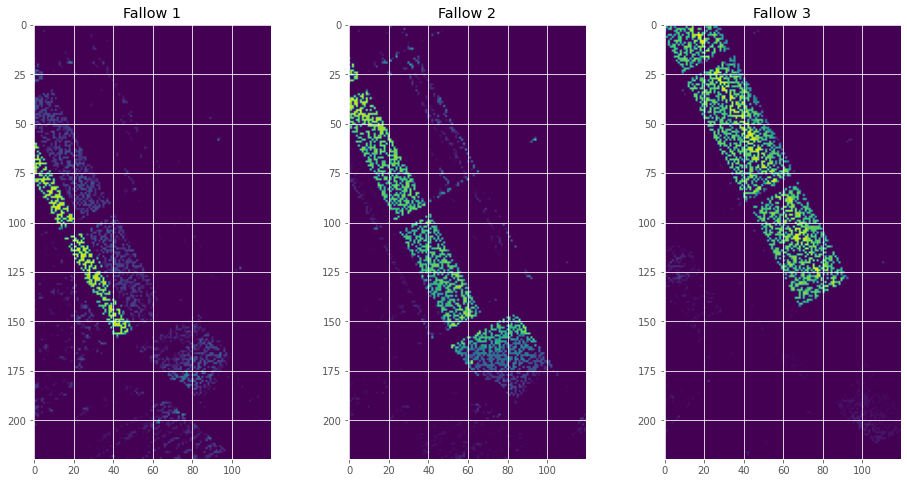

In [66]:
endmembers=["Fallow 1", "Fallow 2", "Fallow 3"]
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

for i in range(3):
    axs[i].imshow(lasso_thetas[:,:,i + 2])
    axs[i].set_title(endmembers[i])